In [6]:
import sys

import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [7]:
df = pd.read_csv("hotel_reviews.csv")

# drop NaN values for lat and long
df = df.dropna()

# append the positive and negative text reviews
df["combine_review"] = df["Negative_Review"] + df["Positive_Review"]

df["bad_review"] = df["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)

df = df[["combine_review", "bad_review"]]

# remove "no negative" + "no positive" from combined review
df["combine_review"] = df["combine_review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

In [8]:
df = df.sample(frac = 0.1, replace = False, random_state=42)
df

,combine_review,bad_review
188009,everything was fine We stayed one night over...,0
63099,Breakfast at 25 euro each was a bit steep Ev...,0
27034,They completely missed doing room service on ...,0
206553,Internet very very slow and most of the time ...,0
328796,Maybe a small bar area where we could grab a ...,0
...,...,...
428506,The soap dispensers were awkward and a nuisan...,0
433359,The room was fabulous bed so comfortable Soun...,0
221418,Too noise for the room clean staffs,0
206734,Everything was okay Staff were extremely fri...,0


# Tokenize Sentences and Clean

In [9]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.combine_review.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['everything', 'was', 'fine', 'we', 'stayed', 'one', 'night', 'over', 'the', 'easter', 'weekend', 'to', 'celebrate', 'our', 'anniversary', 'hotel', 'was', 'very', 'well', 'decorated', 'and', 'everything', 'was', 'great', 'especially', 'staff', 'were', 'so', 'impressive', 'thanks', 'to', 'guest', 'experience', 'team', 'for', 'looking', 'after', 'us', 'and', 'for', 'the', 'room', 'upgrade']]


## Build Bigram, Trigram Models and Lemmatize

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

## Build the Topic Model

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.076*"hotel" + 0.035*"stay" + 0.033*"room" + 0.024*"well" + 0.022*"view" + '
  '0.018*"little" + 0.018*"night" + 0.018*"reception" + 0.017*"bit" + '
  '0.016*"area"'),
 (1,
  '0.066*"friendly" + 0.050*"hotel" + 0.038*"staff" + 0.032*"location" + '
  '0.026*"perfect" + 0.024*"walk" + 0.024*"close" + 0.023*"time" + '
  '0.022*"station" + 0.017*"free"'),
 (2,
  '0.047*"room" + 0.021*"day" + 0.018*"check" + 0.014*"place" + 0.013*"pay" + '
  '0.013*"book" + 0.012*"water" + 0.012*"give" + 0.012*"ask" + 0.010*"charge"'),
 (3,
  '0.096*"room" + 0.070*"staff" + 0.060*"location" + 0.059*"breakfast" + '
  '0.043*"great" + 0.036*"bed" + 0.032*"helpful" + 0.027*"clean" + '
  '0.025*"comfortable" + 0.024*"small"')]


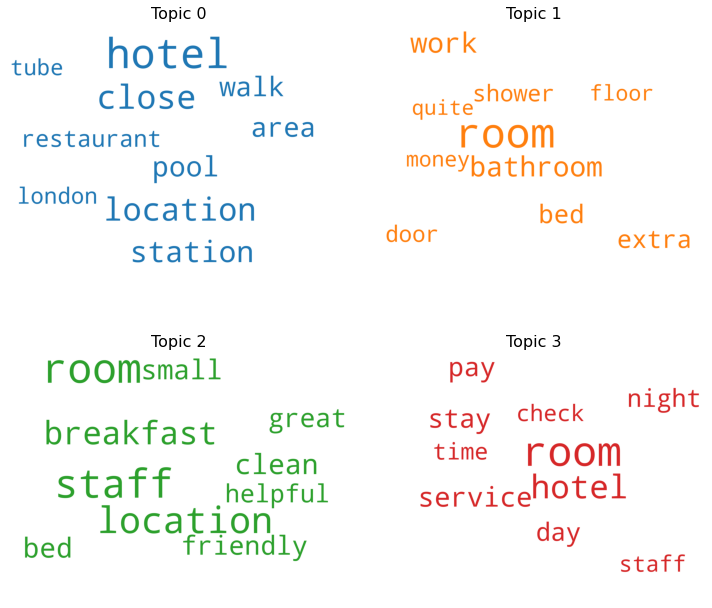

In [7]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## T-SNE plot

In [14]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
import matplotlib.colors as mcolors
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 45399 samples in 0.024s...
[t-SNE] Computed neighbors for 45399 samples in 1.054s...
[t-SNE] Computed conditional probabilities for sample 1000 / 45399
[t-SNE] Computed conditional probabilities for sample 2000 / 45399
[t-SNE] Computed conditional probabilities for sample 3000 / 45399
[t-SNE] Computed conditional probabilities for sample 4000 / 45399
[t-SNE] Computed conditional probabilities for sample 5000 / 45399
[t-SNE] Computed conditional probabilities for sample 6000 / 45399
[t-SNE] Computed conditional probabilities for sample 7000 / 45399
[t-SNE] Computed conditional probabilities for sample 8000 / 45399
[t-SNE] Computed conditional probabilities for sample 9000 / 45399
[t-SNE] Computed conditional probabilities for sample 10000 / 45399
[t-SNE] Computed conditional probabilities for sample 11000 / 45399
[t-SNE] Computed conditional probabilities for sample 12000 / 45399
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...